In [1]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import random
from matplotlib import collections  as mc
%matplotlib inline

import random
import numpy as np
from math import sqrt, pi

import torch
import torch.nn as nn

import torchvision.datasets as datasets
from torchvision import transforms

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm
from copy import deepcopy

from sklearn.datasets import make_swiss_roll

def sq_cost (X, Y):
    return (X-Y).square().flatten(start_dim=1).mean(dim=1)

## Min Config

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

EXPERIMENT = 'SWISS2CIRCLE'
COST = sq_cost
T_ITERS = 10 # how much T updates to do per 1 update of f

if EXPERIMENT in ['SWISS2CIRCLE']:
    MAX_STEPS = 70000 # total number of training steps
    W = 1 # 2/2, 2/1

In [3]:
# Use these functions to sample from the distributions

def sample_from_tensor(t, size=64, loc=-1):
    coords = (torch.rot90(t, -1, [0, 1]) == 1).nonzero(as_tuple=False).detach().cpu().numpy() / 32 / 32 + loc 
    indices = random.choices(range(len(coords)), k=size)
    xy = coords[indices]
    return xy.astype(np.float32)

def sample_normal(size=64, loc=(0, 0), scale=(0.2, 0.2)):
    return np.random.normal(size=(size,2), loc=loc, scale=scale).astype(np.float32)

def sample_swiss(size=64):
    return make_swiss_roll(
        n_samples=size, noise=0.3
    )[0].astype('float32')[:, [0, 2]] / 18

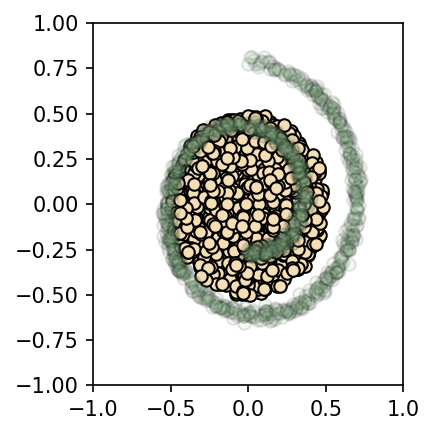

In [4]:
if EXPERIMENT == 'SWISS2CIRCLE':
    X = sample_swiss(size=1024)
    
    im = Image.open('../pics/circle.png')
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((32*32, 32*32)),
                                   ])
    t = transform(im)[0].float()
    t = (t < 0.5).float()
    
    Y = sample_from_tensor(t, 1024, loc=(-0.5, -0.5))
    fig, axes = plt.subplots(1, 1, figsize=(3,3), dpi=150, sharex=True, sharey=True)

    axes.set_xlim(-1, 1);
    axes.set_ylim(-1, 1);

axes.scatter(Y[:,0], Y[:, 1], c='wheat', edgecolors='black')
axes.scatter(X[:,0], X[:, 1], c='darkseagreen', edgecolors='black', alpha=0.1)
fig.tight_layout()

## Initializing networks

In [5]:
class NegAbs(nn.Module):
    def __init__(self):
        super(NegAbs, self).__init__()

    def forward(self, input):
        return -torch.abs(input)
        
if EXPERIMENT in ['SWISS2CIRCLE']:
    T = nn.Sequential(
        nn.Linear(2, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 2),
    ).to(DEVICE)

    f = nn.Sequential(
        nn.Linear(2, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Linear(512, 1),
        NegAbs(),
    ).to(DEVICE)
    
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 527874
f params: 527361


In [6]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-4, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

In [15]:
if EXPERIMENT == 'SWISS2CIRCLE':
    X_fixed = sample_swiss(size=1024)
    Y_fixed = sample_from_tensor(t, 1024, loc=(-0.5, -0.5))

## Training

In [8]:
from src.tools import calculate_cost

In [ ]:
# NOT perfect algorithm
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    T.train(True); f.eval()
    for t_iter in range(T_ITERS):
        if EXPERIMENT == 'SWISS2CIRCLE':
            X = sample_swiss(size=1024)
        X = torch.tensor(X, device=DEVICE)
        T_loss = COST(X, T(X)).mean() - f(T(X)).mean()
        T_opt.zero_grad(); T_loss.backward(); T_opt.step()

    # f optimization
    T.eval(); f.train(True)
    if EXPERIMENT == 'SWISS2CIRCLE':
        X = sample_swiss(size=1024)
        Y = sample_from_tensor(t, 1024, loc=(-0.5, -0.5))

    X = torch.tensor(X, device=DEVICE)
    Y = torch.tensor(Y, device=DEVICE)
    f_loss = f(T(X)).mean() - (W * f(Y)).mean()
    f_opt.zero_grad(); f_loss.backward(); f_opt.step()

    if step % 100 == 0:
        clear_output(wait=True)
        print("Step", step)

        # The code for plotting the results
        fig, axes = plt.subplots(1, 3, figsize=(9,3), dpi=150, sharex=True, sharey=True)
        X_fixed = torch.tensor(X_fixed, device=DEVICE)
        
        cost = COST(X_fixed, T(X_fixed)).mean().item()
        costs.append(cost)
        
        with torch.no_grad():
            T_X_fixed = T(X_fixed).to('cpu').numpy()
            X_fixed = X_fixed.to('cpu').numpy()
        lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
        lc = mc.LineCollection(lines, linewidths=0.5, color='black')
        
        axes[0].add_collection(lc)

        axes[0].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')
        axes[0].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{Q}$')        
        axes[0].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
        axes[1].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', label=r'Mapped $T(x)$')
        axes[2].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', label=r'Target $\mathbb{Q}$')
        axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); axes[2].legend(loc='upper right')

        if EXPERIMENT == ['SWISS2CIRCLE']:
            axes[0].set_xlim(-1, 1);
            axes[1].set_ylim(-1, 1);
        fig.tight_layout(); plt.show()

## Evaluation

tensor(0.0136, device='cuda:0')
tensor(0.0026, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(7.9778e-06, device='cuda:0')


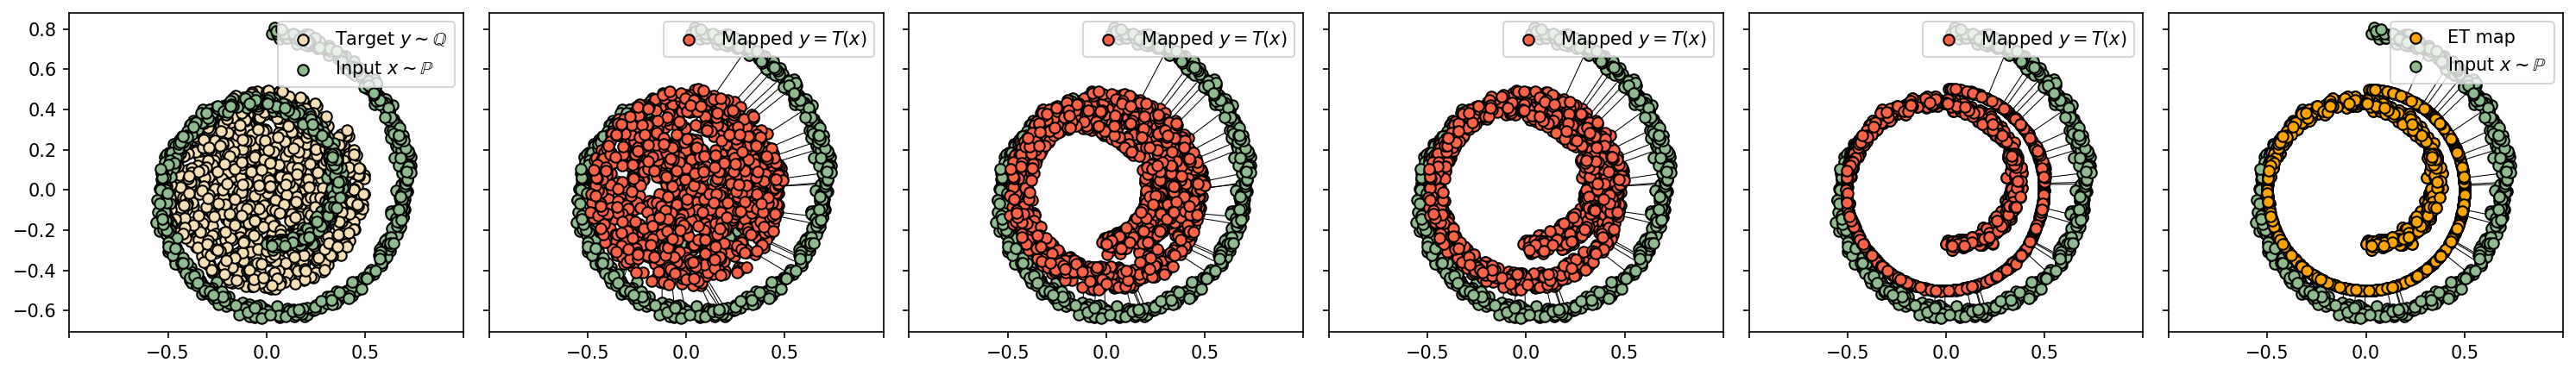

In [70]:
fig, axes = plt.subplots(1, 6, figsize=(20,3), dpi=150, sharex=True, sharey=True)

axes[0].scatter(Y_fixed[:,0], Y_fixed[:, 1], c='wheat', edgecolors='black', zorder=1, label=r'Target $y\sim\mathbb{Q}$')
axes[0].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')

X_fixed = torch.tensor(X_fixed).cuda()
T.eval();
T.load_state_dict(torch.load('../checkpoints/swiss2circle_IT_T_1.pth'))
with torch.no_grad():
    T_X_fixed = T(X_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')
print(COST(torch.tensor(nn, device='cuda'), 
           torch.tensor(T_X_fixed, device='cuda')).mean())

axes[1].add_collection(lc)
axes[1].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[1].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
del T_X_fixed

X_fixed = torch.tensor(X_fixed).cuda()
T.eval();
T.load_state_dict(torch.load('../checkpoints/swiss2circle_IT_T_1.5.pth'))
with torch.no_grad():
    T_X_fixed = T(X_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')
print(COST(torch.tensor(nn, device='cuda'), 
           torch.tensor(T_X_fixed, device='cuda')).mean())

axes[2].add_collection(lc)
axes[2].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[2].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')
del T_X_fixed

X_fixed = torch.tensor(X_fixed).cuda()
T.eval();
T.load_state_dict(torch.load('../checkpoints/swiss2circle_IT_T_2.pth'))
with torch.no_grad():
    T_X_fixed = T(X_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')
print(COST(torch.tensor(nn, device='cuda'), 
           torch.tensor(T_X_fixed, device='cuda')).mean())

axes[3].add_collection(lc)
axes[3].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[3].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')

X_fixed = torch.tensor(X_fixed).cuda()
T.eval();
T.load_state_dict(torch.load('../checkpoints/swiss2circle_IT_T_32.pth'))
with torch.no_grad():
    T_X_fixed = T(X_fixed).to('cpu').numpy()
    X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], T_X_fixed[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')
print(COST(torch.tensor(nn, device='cuda'), 
           torch.tensor(T_X_fixed, device='cuda')).mean())

axes[4].add_collection(lc)
axes[4].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2)#, label=r'Input $x\sim\mathbb{P}$')
axes[4].scatter(T_X_fixed[:,0], T_X_fixed[:, 1], c='tomato', edgecolors='black', zorder=3, label=r'Mapped $y=T(x)$')

X_fixed = torch.tensor(X_fixed).cuda()
nn = (
    (X_fixed.square().sum(axis=1).sqrt() <= 0.5).type(torch.float32)[:, None] * 
    X_fixed 
    + 
    (X_fixed.square().sum(axis=1).sqrt() > 0.5).type(torch.float32)[:, None] * 
    X_fixed * 0.5 / X_fixed.square().sum(axis=1).sqrt()[:, None]
)
nn = nn.to('cpu').numpy()
X_fixed = X_fixed.to('cpu').numpy()
lines =  list(zip(X_fixed[:64], nn[:64]))
lc = mc.LineCollection(lines, linewidths=0.5, color='black')

axes[-1].add_collection(lc)
axes[-1].scatter(nn[:,0], nn[:, 1], c='orange', edgecolors='black', label=r'ET map', zorder=3)
axes[-1].scatter(X_fixed[:,0], X_fixed[:, 1], c='darkseagreen', edgecolors='black', zorder=2, label=r'Input $x\sim\mathbb{P}$')


axes[0].legend(loc='upper right'); axes[1].legend(loc='upper right'); 
axes[2].legend(loc='upper right'); axes[3].legend(loc='upper right');
axes[4].legend(loc='upper right'); axes[5].legend(loc='upper right');
for ax in axes:
#     ax.axes.xaxis.set_ticklabels([])
    xticks = ax.xaxis.get_major_ticks()
    xticks[0].label1.set_visible(False)
    xticks[-1].label1.set_visible(False)

axes[0].set_xlim(-1, 1);
fig.tight_layout(); plt.show()